# REVOLUTIONIZING SKINCARE WITH AI POWERED RECOMMENDATIONS FOR MELANIN RICH SKIN

![2d248f5507752726ddc2198b39071e4e](https://github.com/user-attachments/assets/9c7a2247-b758-4aee-8bc7-50fa0bf76f2d)


## Business Problem
Black women represent a significant demographic in the beauty and skincare industry, yet they face limited access to skincare products tailored to their specific needs, such as hyper- pigmentation, dryness, and sensitivity. Most available recommendation systems overlook the unique skin concerns of Black women, offering general suggestions rather than targeted solutions. This gap impacts consumer satisfaction, as Black women often struggle to find effective products for their melanin-rich skin. 

This project aims to develop a recommendation system using advanced AI techniques to cater specifically to Black women’s skincare needs. By integrating machine learning, content- based filtering, collaborative filtering, and sentiment analysis, the system will offer personalized skincare recommendations. Leveraging skin_tone (Author's skin tone (e.g. fair, tan, etc.) as a classification feature, we aim to distinguish and target products that align with melanin-rich skin concerns.

### Objectives
1. Develop a melanin-centered skincare recommendation system using deep learning, tailored for Black women’s unique skin needs.
2. Utilize content-based and collaborative filtering along with sentiment analysis to enhance recommendation accuracy. 
3. Deploy an accessible Streamlit interface for personalized, user-friendly skincare suggestions. 
4. Integrate Logistic Regression, SVD, and K-means clustering to improve recommendation precision.

### Stakeholders
1. *Users*: Black women seeking tailored skincare solutions. 
2. *Skincare Brands*: Companies interested in product insights for melanin-rich skin. 
3. *Healthcare Professionals*: Dermatologists who may use the system as a recommendation tool. 
4. *AI and Skincare Researchers*: Those exploring AI applications in skincare for under- represented groups.

## Data Understanding:
The dataset was collected via a Python scraper and contains:
- Product Information: Over 8,000 beauty products from the Sephora online store, including product and brand names, prices, ingredients, ratings, and various features. 
- User Reviews: Approximately 1 million reviews across over 2,000 products in the skincare category. These reviews include user appearances, skin types, and review ratings.

The key features include:
- Product Features: `product_id`, `product_name`, `brand_name`, `ingredients`, `rating`, `price_ksh`, `new`, `out_of_stock`, `highlights`. 
- Review Features: `author_id`, `rating`, `review_text`, `skin_type`, `skin_tone`, and
`helpfulness`.

### STEP 1: DATA LOADING

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS # To visualize text data
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, precision_score, recall_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle

In [2]:
# Load the product info and skincare products reviews from Excel files
products = pd.read_csv('data/product_info.xls', encoding = "ISO-8859-1")
reviews = pd.read_csv('data/skincare_products_reviews.xls', encoding = "ISO-8859-1", low_memory=False)

print('Products size:', products.shape)
print('Reviews size:', reviews.shape)

Products size: (8494, 27)
Reviews size: (49977, 19)


In [3]:
# Necessary columns for target analysis
product_columns = [
    'product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 
    'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 
    'ingredients', 'price_usd', 'new', 'out_of_stock', 'highlights', 'primary_category', 
    'secondary_category', 'tertiary_category', 'sephora_exclusive'
]

review_columns = [
    'product_id', 'author_id', 'rating', 'is_recommended', 'helpfulness', 
    'review_text', 'skin_tone', 'skin_type', 'eye_color', 'hair_color', 'submission_time'
]

# Filter columns in each dataset
products_filtered = products[product_columns]
reviews_filtered = reviews[review_columns]

# Merge filtered dataframes on 'product_id'
data = pd.merge(products_filtered, reviews_filtered, on='product_id', how='inner')

# Display merged data info and preview
data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,author_id,rating_y,is_recommended,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time
0,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,6921691467,5,1.0,1.000000,This product is amazing. Makes my skin feel so...,NaN,dry,hazel,blonde,2023-01-02
1,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,40727014792,5,1.0,0.833333,I pair this with the algae niacinamide moistur...,NaN,combination,blue,blonde,2022-11-06
2,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,7186952566,5,1.0,0.625000,Definitely my favorite I use it for under eye ...,NaN,NaN,NaN,NaN,2022-10-05
3,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,2117812169,5,1.0,1.000000,I bought this with the toner as I was looking ...,light,combination,green,brown,2022-09-15
4,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,12538328524,5,1.0,0.888889,Been using for months now. I went in and asked...,fair,NaN,NaN,NaN,2022-06-02


### STEP 2: DATA PRE-PROCESSING

In [4]:
# Checking for duplicates
data.duplicated().sum()

0

In [5]:
# Handling missing values
missing = []
unique = []
types = []
variables = []
count = []

for item in data.columns:
    variables.append(item)
    missing.append(data[item].isnull().sum())
    unique.append(data[item].nunique())
    types.append(data[item].dtypes)
    count.append(len(data[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})
print("Data info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)

Data info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,49977,5,49585
1,helpfulness,float64,49977,1209,13455
2,highlights,object,49977,750,11513
3,variation_value,object,49977,283,10338
4,variation_type,object,49977,5,9052
5,hair_color,object,49977,7,8851
6,size,object,49977,280,8615
7,skin_tone,object,49977,14,7201
8,tertiary_category,object,49977,29,6996
9,eye_color,object,49977,6,6260


In [6]:
# Define threshold for missing values (e.g., 50%)
threshold = 0.5

# Calculate the percentage of missing values for each column
output['missing_percentage'] = output['missing'] / output['count']

# List columns with missing values above the threshold
columns_to_drop = output[output['missing_percentage'] > threshold]['variable'].tolist()

# Drop these columns from the data
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print("Dropped columns with over 50% missing values:", columns_to_drop)

Dropped columns with over 50% missing values: ['variation_desc']


In [7]:
# Drop rows with missing values
data.dropna(axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16060 entries, 3 to 49969
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          16060 non-null  object 
 1   product_name        16060 non-null  object 
 2   brand_id            16060 non-null  int64  
 3   brand_name          16060 non-null  object 
 4   loves_count         16060 non-null  int64  
 5   rating_x            16060 non-null  float64
 6   reviews             16060 non-null  float64
 7   size                16060 non-null  object 
 8   variation_type      16060 non-null  object 
 9   variation_value     16060 non-null  object 
 10  ingredients         16060 non-null  object 
 11  price_usd           16060 non-null  float64
 12  new                 16060 non-null  int64  
 13  out_of_stock        16060 non-null  int64  
 14  highlights          16060 non-null  object 
 15  primary_category    16060 non-null  object 
 16  secondary

In [8]:
data.shape

(16060, 29)

In [9]:
# Basic Statistical Overview
data.describe()

,brand_id,loves_count,rating_x,reviews,price_usd,new,out_of_stock,sephora_exclusive,rating_y,is_recommended,helpfulness
count,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000
mean,5894.136426,9793.330635,4.203908,75.435679,61.749730,0.039228,0.055044,0.297073,4.140847,0.786800,0.773630
std,1377.326239,8030.100198,0.440261,36.497593,58.752432,0.194143,0.228072,0.456983,1.307110,0.409581,0.299565
min,1073.000000,0.000000,1.846200,1.000000,3.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5946.000000,3993.000000,3.963400,46.000000,28.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.666667
50%,6272.000000,7740.000000,4.255100,75.000000,43.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.900000
75%,6357.000000,12520.000000,4.538500,105.000000,73.000000,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000
max,8017.000000,43971.000000,5.000000,139.000000,400.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000


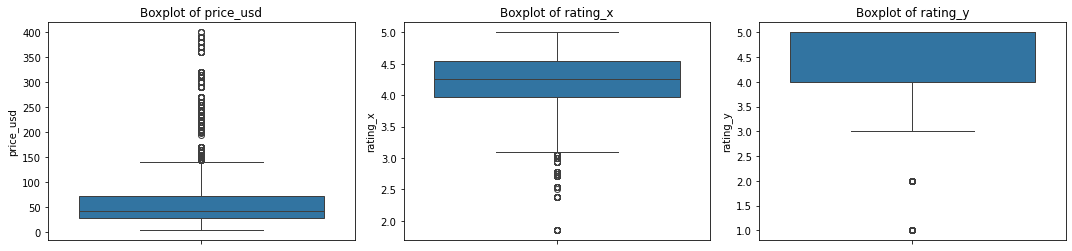

In [10]:
# Identifying Outliers with Boxplots

# Create a list of columns to visualize
columns = ['price_usd', 'rating_x',  'rating_y']

# Create boxplots for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)  # Adjust the layout as needed
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

The **price (USD)** boxplot indicates that a number of products are significantly more expensive than the median range, suggesting high-end or luxury skincare items. For **ratings** (both Rating X and Rating Y), the boxplots show several low-rating outliers, indicating products that have received consistent negative feedback.

Premium products and low ratings can be normal in skincare data, especially when catering to diverse skin types and preferences. High-end products often have niche ingredients or technologies, which can drive up prices, and it’s common to see a range of ratings due to individual experiences. 

To make a more informed decision, we need to examine the exact values of the prices to see if they’re extreme enough to warrant special handling or if they are within a reasonable range.

In [11]:
# Define a function to identify outliers based on IQR
def find_outliers(data, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define outliers as values outside the range (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Return rows with outlier values
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)][[column]]

# Identify outliers for price(ksh) column
price_outliers = find_outliers(data, 'price_usd')
print("Price Outliers:\n", price_outliers)

Price Outliers:
        price_usd
1451       290.0
1452       290.0
1453       290.0
1454       290.0
1455       290.0
...          ...
46162      260.0
46163      260.0
46164      260.0
46165      260.0
46166      260.0

[1194 rows x 1 columns]


These prices are likely for premium or luxury skincare products, which are typically more expensive due to factors like specialized ingredients, brand positioning, or exclusive benefits. Since some users may prefer high-end products, keeping these premium options in the dataset is valid. We'll proceed by segmenting the products into price tiers (e.g., budget, mid-range, premium).

### FEATURE ENGINEERING

Creating a new 'skin_tone_category' column to classify skin tones as 'melanated' or 'non-melanated'. By grouping skin tones we can focus our analysis and modeling efforts on characteristics most relevant to our target audience, ensuring more accurate and personalized recommendations for melanated skin types.

Additionally, we perform other essential feature engineering tasks, including converting the `submission_time` column from an object data type to a datetime format. This conversion enables effective manipulation of time-related data and analysis of trends. We also create a new `price_ksh` column that converts prices from US dollars to Kenyan Shillings using the exchange rate of 1 USD = 129.27 KSH, facilitating financial analysis in the local currency.

In [12]:
# Lists of skin tones categorized as 'light' or 'dark'
light_skin_tones = ['light', 'fair', 'lightMedium', 'fairLight', 'porcelain', 'olive']
dark_skin_tones = ['mediumTan', 'medium', 'tan', 'rich', 'deep', 'dark']
# Creating a new column 'skin_tone_category' with 'light' and 'dark' values
data['skin_tone_category'] = data['skin_tone'].apply(lambda x: 'non-melanated' if x in light_skin_tones else 'melanated' if x in dark_skin_tones else 'other')

# Convert 'submission_time' to datetime format
data['submission_time'] = pd.to_datetime(data['submission_time'], errors='coerce')

# Creating a new column 'price_ksh'
data['price_ksh'] = (data['price_usd'] * 129.27)

# Define a function to categorize products by price
def categorize_price(price):
    if price < 5000:
        return 'Budget'
    elif 5000 <= price <= 15000:
        return 'Mid-Range'
    else:
        return 'Premium'

# Apply the function to create a new column 'price_tier'
data['price_tier'] = data['price_ksh'].apply(categorize_price)

# Check the distribution of products in each price tier
print(data['price_tier'].value_counts())

price_tier
Mid-Range    7479
Budget       6939
Premium      1642
Name: count, dtype: int64


In [13]:
# Saving the cleaned dataset to csv file
data.to_csv('data.csv')

data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time,skin_tone_category,price_ksh,price_tier
3,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,I bought this with the toner as I was looking ...,light,combination,green,brown,2022-09-15,non-melanated,7497.66,Mid-Range
5,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,0.833333,"When this product was recommended to me, I was...",fair,combination,brown,blonde,2021-11-18,non-melanated,7497.66,Mid-Range
8,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,0.777778,this is my first ever purchase from algenist a...,light,oily,brown,black,2021-07-30,non-melanated,7497.66,Mid-Range
9,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,When stressed skin starts to burn this seems t...,light,dry,blue,brown,2021-05-17,non-melanated,7497.66,Mid-Range
10,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,Sample was sitting in my drawer for months bef...,fair,combination,blue,blonde,2021-05-10,non-melanated,7497.66,Mid-Range


### STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

#### UNIVARIATE ANALYSIS

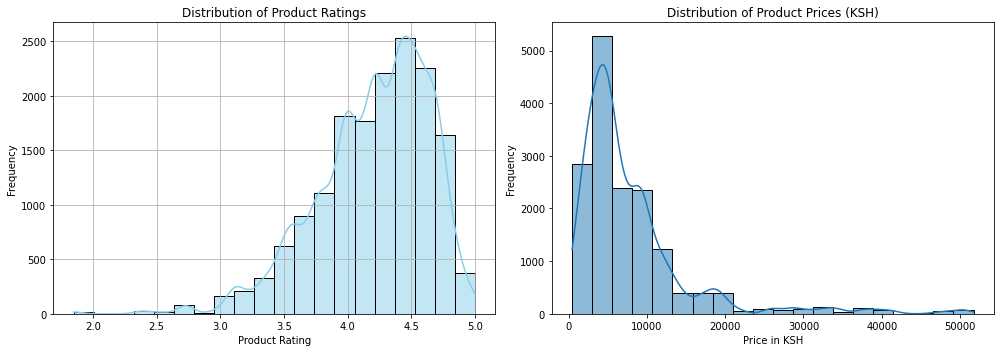

In [14]:
# Distribution of Ratings and Price(ksh)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Visualizing Distribution of Ratings
sns.histplot(data['rating_x'], bins=20, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Product Ratings')
ax1.set_xlabel('Product Rating')
ax1.set_ylabel('Frequency')
ax1.grid()

# Price Distribution
sns.histplot(data['price_ksh'], bins=20, kde=True, ax=ax2)
ax2.set_title('Distribution of Product Prices (KSH)')
ax2.set_xlabel('Price in KSH')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Histogram 1: Most products seem to have higher ratings, indicating a general satisfaction among customers. The peak around the highest rating suggests that products on this platform are generally well-received, though a minority of products still receive lower scores. This distribution helps set expectations for the customer satisfaction range across products.

Histogram 2: The majority of products fall within a low-to-mid price range, suggesting affordability options across the market. This concentration can aid in identifying budget-friendly options for skincare that may appeal to diverse skin tones.

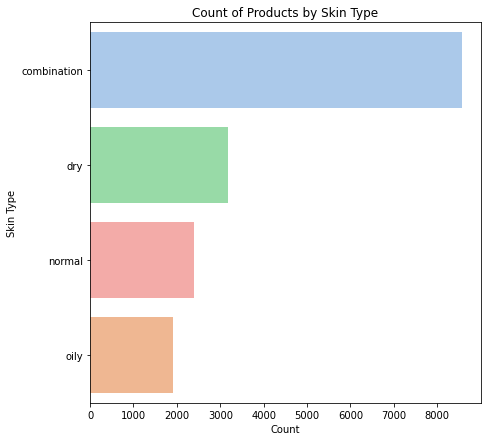

In [15]:
# Count of Products by Skin Type
plt.figure(figsize=(7, 7))
sns.countplot(y='skin_type', data=data, order=data['skin_type'].value_counts().index, palette='pastel', hue='skin_type')
plt.title('Count of Products by Skin Type')
plt.xlabel('Count')
plt.ylabel('Skin Type')
plt.show()

The distribution shows that products labeled for combination skin are the most common, followed by those for dry, normal, and then oily skin. This insight can guide product selection based on prevalent skin types and consumer demand within the Black women demographic.

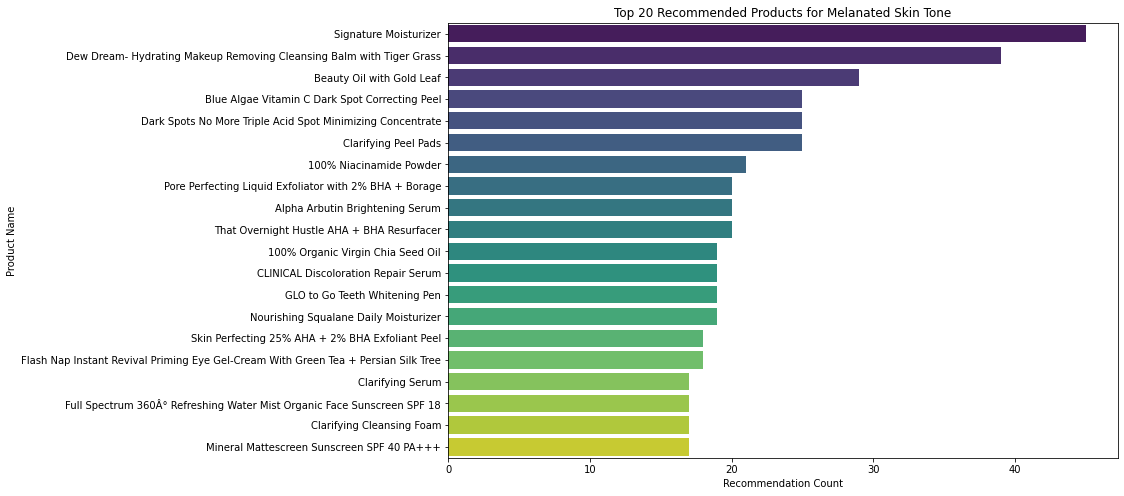

In [16]:
# Top 20 recommended products for melanated skin tone

# Filter data for melanated skin tone and recommended products
melanated_data = data[(data['skin_tone_category'] == 'melanated') & (data['is_recommended'] == 1)]

# Group by product name and count recommendations, selecting the top 20
top_products = melanated_data['product_name'].value_counts().nlargest(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y=top_products.index, x=top_products.values, palette="viridis")
plt.title('Top 20 Recommended Products for Melanated Skin Tone')
plt.xlabel('Recommendation Count')
plt.ylabel('Product Name')
plt.show()

The chart highlights skincare products tailored to the specific needs of melanated skin, focusing on hydration, hyperpigmentation, and sun protection. **Signature Moisturizer** leads with the highest recommendation count, emphasizing a strong demand for deep hydration. Products targeting dark spots, such as **Blue Algae Vitamin C Dark Spot Correcting Peel**, show the importance of tone-evening solutions, while sunscreens like **Mineral MatteSunscreen SPF 40 PA+++** address the need for effective sun protection without a white cast. This selection showcases a commitment to skincare that respects and meets the unique requirements of darker skin tones.

#### BIVARIATE ANALYSIS

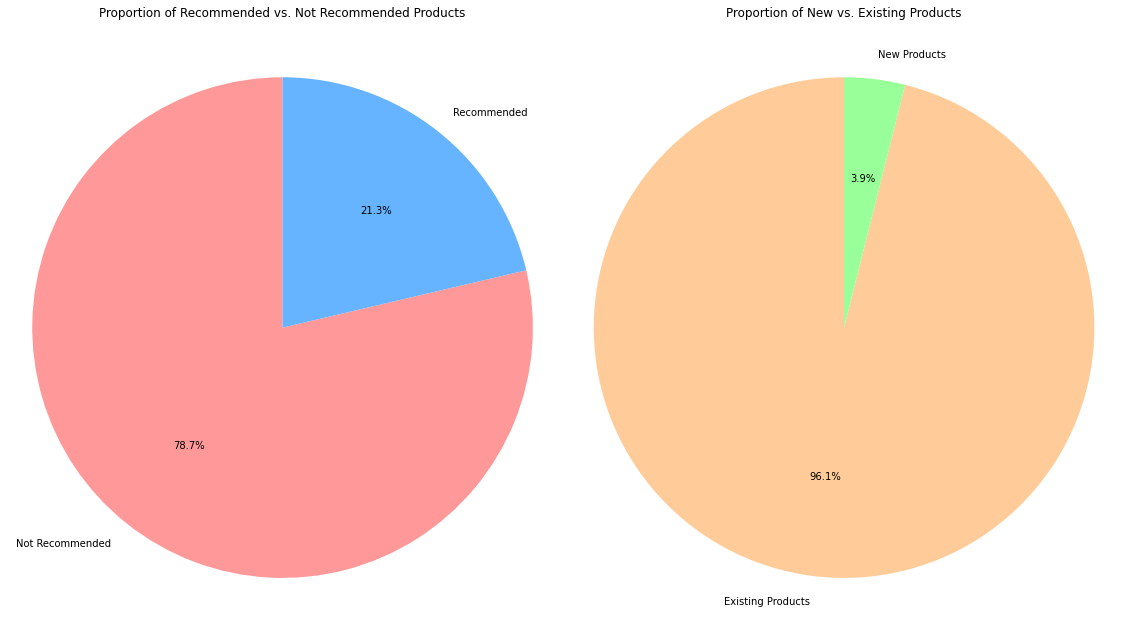

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

# Pie chart for Recommended vs Not Recommended
recommendation_counts = data['is_recommended'].value_counts()
ax1.pie(recommendation_counts, labels=['Not Recommended', 'Recommended'], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B3FF'])
ax1.set_title('Proportion of Recommended vs. Not Recommended Products')
ax1.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Pie chart for New vs Existing Products
new_counts = data['new'].value_counts()
ax2.pie(new_counts, labels=['Existing Products', 'New Products'], autopct='%1.1f%%', startangle=90, colors=['#FFCC99', '#99FF99'])
ax2.set_title('Proportion of New vs. Existing Products')
ax2.axis('equal')

plt.tight_layout()
plt.show()

The **Recommended** pie chart illustrates the percentage of products recommended versus those that are not. A significant portion (78.7%) of products are not marked as recommended, indicating a possible quality or suitability gap. This could help identify where product performance might fall short or suggest a need for more tailored product options.

The **Products** pie chart shows the balance between new and existing products. The larger percentage of existing products (96.1%) suggests that the platform maintains a consistent range of products, with newer items being introduced selectively. This distribution can provide insights into the inventory management and refresh rates of the catalog over time.

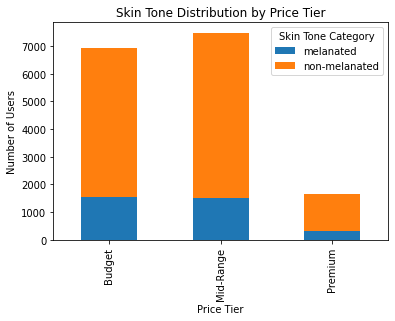

In [18]:
skin_tone_tier = data.groupby(['price_tier', 'skin_tone_category']).size().unstack()
skin_tone_tier.plot(kind='bar', stacked=True)
plt.title('Skin Tone Distribution by Price Tier')
plt.xlabel('Price Tier')
plt.ylabel('Number of Users')
plt.legend(title='Skin Tone Category')
plt.show()

There is a noticeable price difference across skin tones. Products for melanated skin tend to have lower average prices, than non-melanated skin tones, highlighting more affordable options specifically formulated or suited for melanated skin. 

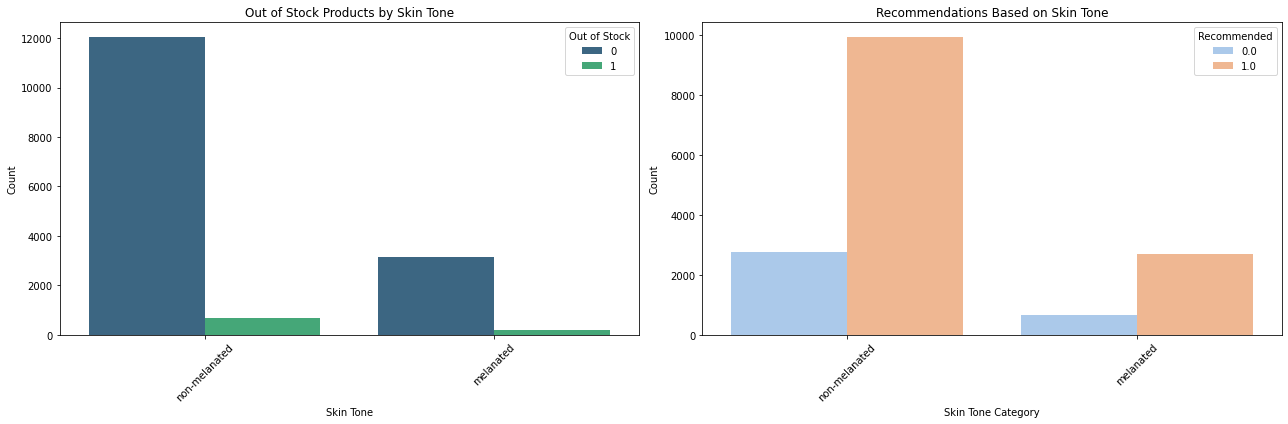

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Out of Stock by Skin Tone
sns.countplot(x='skin_tone_category', hue='out_of_stock', data=data, palette='viridis', ax=ax1)
ax1.set_title('Out of Stock Products by Skin Tone')
ax1.set_xlabel('Skin Tone')
ax1.set_ylabel('Count')
ax1.legend(title='Out of Stock')
ax1.tick_params(axis='x', rotation=45)

# Recommendations by Skin Tone
sns.countplot(x='skin_tone_category', hue='is_recommended', data=data, palette='pastel', ax=ax2)
ax2.set_title('Recommendations Based on Skin Tone')
ax2.set_xlabel('Skin Tone Category')
ax2.set_ylabel('Count')
ax2.legend(title='Recommended')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Lighter skin tones show a higher count of both in-stock and out-of-stock products. This contrasts with deep skin tones which have fewer options overall and lower in-stock counts. This discrepancy might indicate a supply gap for these deeper skin tones, which are more likely to face limited product availability.

Products targeting melanated skin tones receive fewer recommendations, suggesting that product options may not fully address the needs or preferences of these individuals.

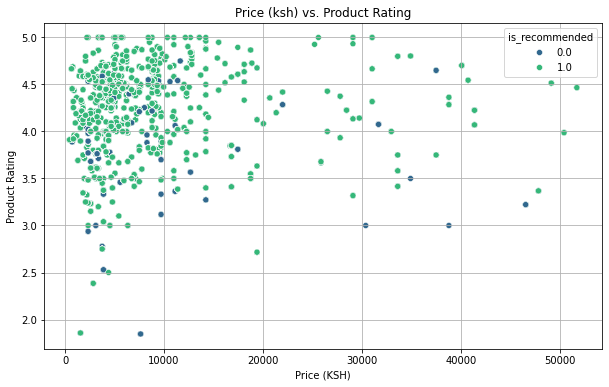

In [20]:
# Correlation between Ratings and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='price_ksh', y='rating_x', hue='is_recommended', palette='viridis')
plt.title('Price (ksh) vs. Product Rating')
plt.xlabel('Price (KSH)')
plt.ylabel('Product Rating')
plt.grid()
plt.show()

The scatter plot shows the relationship between product price and customer ratings. Although there is no strong correlation, products in the low-to-mid price range tend to receive favorable ratings, suggesting that affordability does not necessarily compromise quality. This insight may encourage users to explore budget-friendly options without sacrificing product satisfaction.

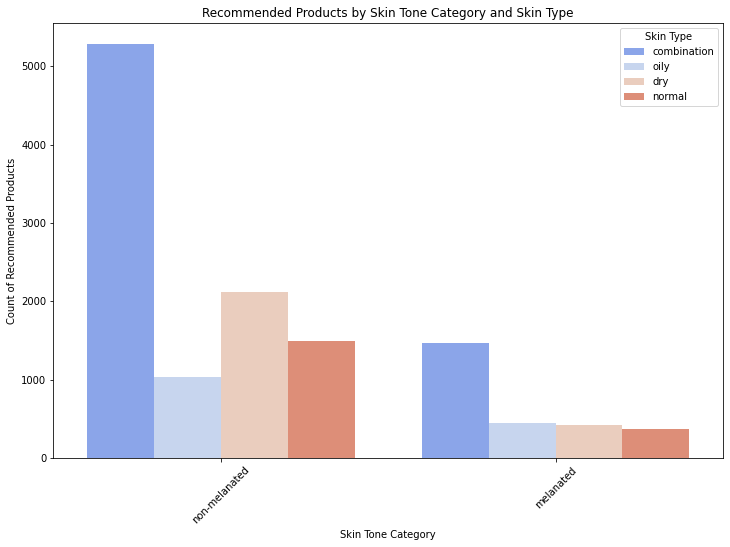

In [21]:
# Count of Recommended Products by Skin Tone and Skin Type
plt.figure(figsize=(12, 8))
sns.countplot(x='skin_tone_category', hue='skin_type', data=data[data['is_recommended'] == 1], palette='coolwarm')
plt.title('Recommended Products by Skin Tone Category and Skin Type')
plt.xlabel('Skin Tone Category')
plt.ylabel('Count of Recommended Products')
plt.xticks(rotation=45)
plt.legend(title='Skin Type')
plt.show()

There are more recommended product options for combination and dry skin types across lighter skin tones. This trend highlights a potential focus on lighter tones in product recommendations, which may overlook the unique needs of Black women with deeper skin tones and varied skin types.

#### MULTIVARIATE ANALYSIS

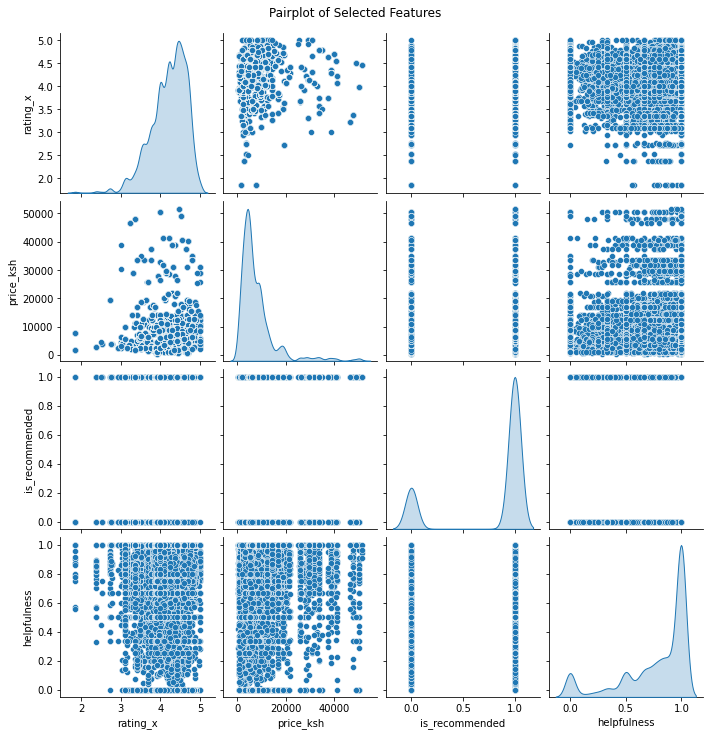

In [22]:
# Pairplot for Selected Features
selected_features = ['rating_x', 'price_ksh', 'is_recommended', 'helpfulness']
sns.pairplot(data[selected_features], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

The pair plot examines relationships between selected numeric features, such as rating, price(Ksh), and helpfulness. The absence of clear patterns in most pairwise relationships suggests limited linear correlation among these variables. However, this view offers insight into the variability and potential interactions within the data, aiding in feature selection and engineering for subsequent modeling.

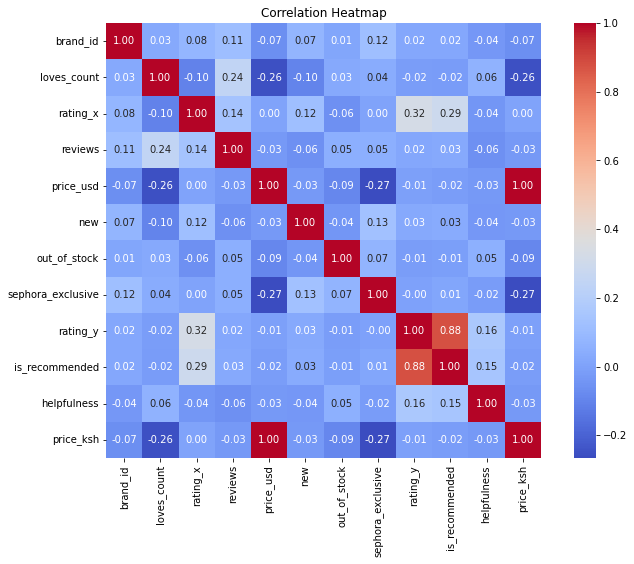

In [23]:
# Heatmap of Correlation Between Numeric Features
plt.figure(figsize=(12, 8))

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Calculate correlation only on numeric columns
correlation = numeric_data.corr()

# Create the heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows weak to moderate correlations between numeric features, with notable clusters indicating relationships. 

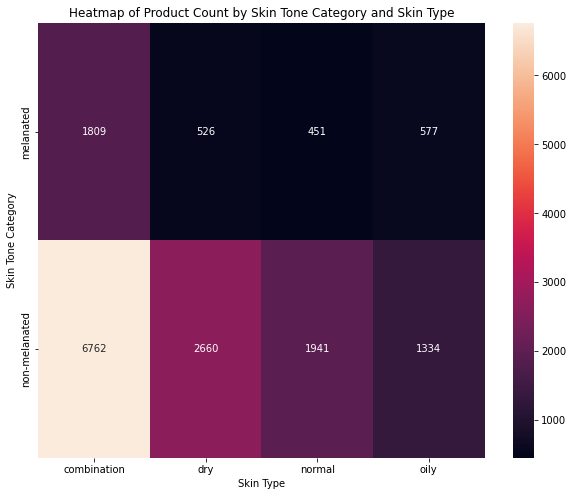

In [24]:
# Create a contingency table
contingency_table = pd.crosstab(index=data['skin_tone_category'], columns=data['skin_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title('Heatmap of Product Count by Skin Tone Category and Skin Type')
plt.xlabel('Skin Type')
plt.ylabel('Skin Tone Category')
plt.show()

The heatmap analysis of `skin_type` and `skin_tone_category` highlights important insights that align closely with our objective of providing tailored skincare recommendations for Black women. Our data reveals a concentration of products available for combination and dry skin types, particularly within lighter skin tones. However, there is a notable scarcity of options for deeper skin tones, suggesting that Black women may have fewer product options specifically suited to their needs. This gap underscores the limited market focus on skincare for melanin-rich skin concerns, such as hyperpigmentation, dryness, and sensitivity, which are often more pronounced in deeper skin tones.

These findings directly support our business problem: many existing recommendation systems fail to provide targeted solutions for Black women. The evident lack of specialized options for drier skin in deeper tones emphasizes an opportunity to develop and recommend products that address this unique need. By prioritizing these underserved areas, our recommendation system can significantly enhance satisfaction and efficacy for Black women seeking products that work for their melanin-rich skin.

### STEP 4: MODELING

### 1. SENTIMENT ANALYSIS

In [25]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Han\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
# Filter data to include only rows where skin_tone_category is 'melanated'
melanated_data = data[data['skin_tone_category'] == 'melanated']

# Initialize stop words, stemmer, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define a function for text cleaning
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing function to the review text
melanated_data['cleaned_review_text'] = melanated_data['review_text'].apply(preprocess_text)

In [27]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']  # Compound score provides a single sentiment score

# Apply sentiment analysis to the preprocessed review text
melanated_data['sentiment_score'] = melanated_data['cleaned_review_text'].apply(get_sentiment)

In [28]:
# Define a function to classify sentiment scores
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function
melanated_data['sentiment_category'] = melanated_data['sentiment_score'].apply(classify_sentiment)

# Check the distribution of sentiment categories
print(melanated_data['sentiment_category'].value_counts())

sentiment_category
Positive    2965
Negative     279
Neutral      119
Name: count, dtype: int64


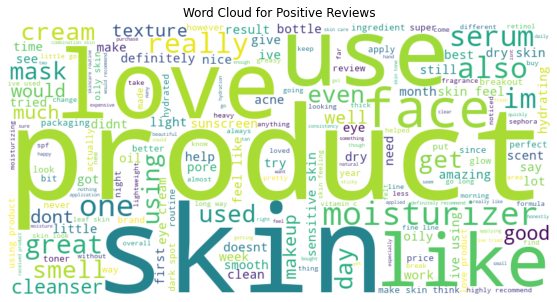

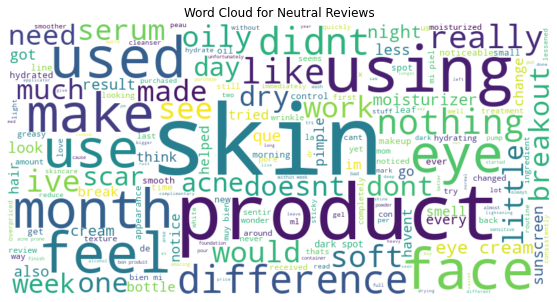

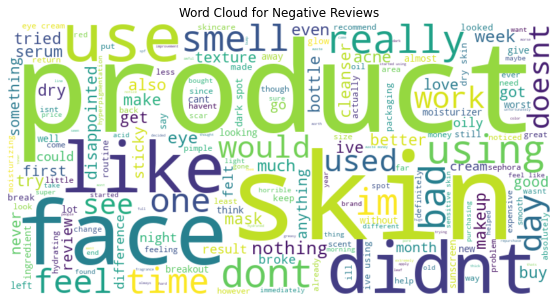

In [29]:
# Generate word clouds for each sentiment category
for sentiment in ['Positive', 'Neutral', 'Negative']:
    text = ' '.join(melanated_data[melanated_data['sentiment_category'] == sentiment]['cleaned_review_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, colormap='viridis').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Reviews')
    plt.show()

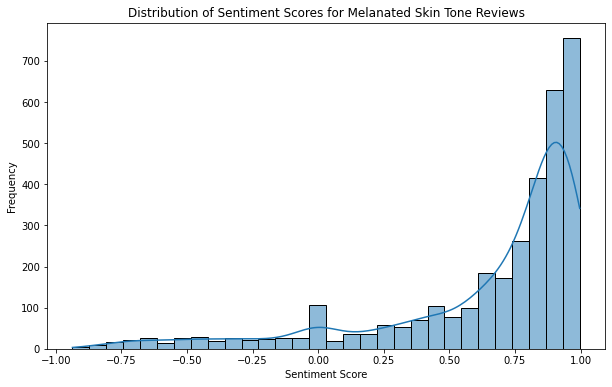

In [30]:
# Plot sentiment score distribution
plt.figure(figsize=(10, 6))
sns.histplot(melanated_data['sentiment_score'], kde=True, bins=30)
plt.title('Distribution of Sentiment Scores for Melanated Skin Tone Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Most sentiment scores fall between 0.75 and 1.0, indicating a large proportion of highly favorable reviews. This right-skewed distribution suggests that users with melanated skin tones generally have positive experiences, as evidenced by the high frequency of positive sentiment scores. There is a smaller cluster of scores around the 0 to 0.25 range, which could represent neutral to mildly positive reviews, potentially indicating some mixed feedback or moderate satisfaction. Notably, there are very few reviews with negative sentiment scores below 0, implying that negative feedback is rare within this dataset. Overall, this pattern suggests a strong level of satisfaction.

### 2. KNN

Using K-Nearest Neighbors (KNN) with ingredients as features to identify similar products based on their ingredient composition. This will help in recommending products with similar benefits or formulations for users with specific skin tones and types.

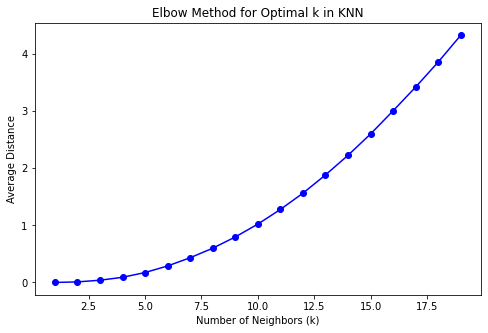

In [31]:
from sklearn.neighbors import NearestNeighbors

# Vectorize the ingredients
vectorizer = TfidfVectorizer(stop_words='english')
ingredient_matrix = vectorizer.fit_transform(melanated_data['ingredients'].fillna(""))

# Define a range of k values to try
k_values = range(1, 20)
errors = []

# Calculate WCSS (within-cluster sum of squares) for each k
for k in k_values:
    knn = NearestNeighbors(n_neighbors=k, metric='cosine')
    knn.fit(ingredient_matrix)
    
    # Sum of distances to the nearest k neighbors
    distances, _ = knn.kneighbors(ingredient_matrix)
    wcss = np.sum(distances) / len(distances)  # Calculate average distance
    
    errors.append(wcss)

# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, 'bo-', markersize=6)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.title('Elbow Method for Optimal k in KNN')
plt.show()

In [32]:
# Initialize and fit the KNN model using the optimal k
k = 5
knn = NearestNeighbors(n_neighbors=k, metric='cosine')
knn.fit(ingredient_matrix)

# Query for recommendations
def get_recommendations(product_id):
    product_index = melanated_data[melanated_data['product_id'] == product_id].index[0]
    distances, indices = knn.kneighbors(ingredient_matrix[product_index], n_neighbors=k)
    
    recommended_products = melanated_data.iloc[indices[0]]
    return recommended_products[['product_id', 'product_name', 'brand_name', 'price_usd']]

# Test Recommendation for a Sample Product
product_id = data['product_id'].iloc[0] 
recommendations = get_recommendations(product_id)
print(f"Since you liked product {product_id}, you might also like :")
print(recommendations)

Since you liked product P453818, you might also like :
    product_id                    product_name brand_name  price_usd
196    P442859  ALIVE Prebiotic Balancing Mask   Algenist       38.0
195    P442859  ALIVE Prebiotic Balancing Mask   Algenist       38.0
223    P442859  ALIVE Prebiotic Balancing Mask   Algenist       38.0
229    P442859  ALIVE Prebiotic Balancing Mask   Algenist       38.0
201    P442859  ALIVE Prebiotic Balancing Mask   Algenist       38.0


### 3. HYBRID RECOMMENDATION SYSTEM

Our recommendation system can enhance satisfaction and efficacy for Black women by using data-driven insights from the heatmap to spotlight and prioritize products that meet specific, underserved needs. For instance, with the observed lack of options for dry skin in deeper skin tones, our system can recommend products designed to address hydration and moisture retention, which are critical for managing dryness in melanin-rich skin. Additionally, by identifying gaps for specific skin tones and types, we can curate products with ingredients that target common issues like hyperpigmentation or sensitivity—problems particularly relevant to Black women.

Through advanced filtering, collaborative filtering, and sentiment analysis, our system can highlight well-rated products that align with these needs, even if they’re currently under-marketed for Black women. By promoting these options and analyzing user feedback, the system can gradually refine and adjust recommendations, helping users find products that not only align with their skin type and tone but also actively address their unique skin concerns. This targeted approach leads to more effective skincare routines, as users are less likely to waste time or money on unsuitable products, ultimately increasing both satisfaction and loyalty to our recommendation platform.

### A. Content-Based Filtering Model
- We’ll start with a content-based filtering model using TF-IDF on ingredients and other product features.The aim is to recommend similar products based on ingredients and product features.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create TF-IDF matrix for the ingredients column
tfidf = TfidfVectorizer(stop_words='english')
ingredients_matrix = tfidf.fit_transform(data['ingredients'])

# Calculate cosine similarity for products based on ingredient features
cosine_sim = cosine_similarity(ingredients_matrix, ingredients_matrix)
# Calculate Cosine Similarity for Products based on Ingredient features
cosine_sim = cosine_similarity(ingredients_matrix)

# Function to Recommend Products based on Content Similarity
def content_based_recommendations(product_id, top_n=5):
    idx = data.index[data['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return data['product_name'].iloc[product_indices]

# Test Recommendation for a Sample Product
sample_product_id = data['product_id'].iloc[0]
print(f"Since you liked product {product_id}, you might also like :")
print(content_based_recommendations(sample_product_id))

Since you liked product P453818, you might also like :
5     GENIUS Collagen Calming Relief
8     GENIUS Collagen Calming Relief
9     GENIUS Collagen Calming Relief
10    GENIUS Collagen Calming Relief
11    GENIUS Collagen Calming Relief
Name: product_name, dtype: object


### B. Collaborative Filtering with SVD
- Now we’ll implement collaborative filtering using SVD to capture latent user-product interactions.The goal is to use Matrix Factorization (SVD) on the user-product interaction data for collaborative recommendations.

In [34]:
from sklearn.decomposition import TruncatedSVD

# Create User-Product Interaction Matrix
user_product_matrix = data.pivot_table(index='author_id', columns='product_id', values='rating_x').fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(user_product_matrix)

# Recommending Top Products for a User
def collaborative_recommendations(user_id, top_n=5):
    user_index = data.index[data['author_id'] == user_id].tolist()[0]
    scores = latent_matrix[user_index].dot(latent_matrix.T)
    top_recommendations = scores.argsort()[-top_n:][::-1]
    return data['product_name'].iloc[top_recommendations]

# Test Recommendation for a Sample User
sample_user_id = data['author_id'].iloc[0]
print("Collaborative Filtering Recommendations:")
print(collaborative_recommendations(sample_user_id))

Collaborative Filtering Recommendations:
36768                    Signature Moisturizer
32143              Truth Serum Vitamin C Serum
34276     CLEAR Pore Normalizing Acne Cleanser
8312                   Brightening Face Lotion
14643    2-in-1 Cleansing Oil + Makeup Remover
Name: product_name, dtype: object


### C. Sentiment Analysis on Review Text
- We'll use NLTK's Sentiment Intensity Analyzer for sentiment scoring on reviews.The goal being to analyze review_text for sentiment to refine recommendations based on positive feedback.

In [35]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Function to Recommend Products Based on Positive Sentiments
def sentiment_based_recommendations(user_id, top_n=5):
    user_reviews = data[data['author_id'] == user_id]
    positive_reviews = user_reviews[user_reviews['sentiment_score'] > 0.2]
    return positive_reviews['product_name'].head(top_n)

# Test Sentiment-Based Recommendation
print("Sentiment-Based Recommendations:")
print(sentiment_based_recommendations(sample_user_id))

Sentiment-Based Recommendations:
3    GENIUS Collagen Calming Relief
Name: product_name, dtype: object


### Machine Learning and Deep Learning Models

In [36]:
# Label encode categorical features
categorical_features = ['brand_name', 'variation_type', 'primary_category', 'secondary_category', 'tertiary_category', 
                        'skin_tone', 'skin_type', 'eye_color', 'hair_color']
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Scale numeric features
scaler = StandardScaler()
numeric_features = ['loves_count', 'rating_x', 'reviews', 'price_usd', 'helpfulness']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

### Generate BERT Embeddings for review_text

In [37]:
from transformers import BertTokenizer, BertModel
import torch

In [38]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to create embeddings from review text
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()


In [ ]:
# Apply the function to create BERT embeddings and add as features
data['bert_embeddings'] = data['review_text'].apply(get_bert_embeddings)

# Remove the extra dimension
bert_embeddings_df = pd.DataFrame(data['bert_embeddings'].apply(lambda x: x.squeeze()).tolist(), index=data.index)

# Drop 'review_text' column and merge embeddings with data
data = pd.concat([data, bert_embeddings_df], axis=1).drop(columns=['review_text', 'bert_embeddings'])


#### Drop Unnecessary Columns
Now that we’ve vectorized ingredients and review_text, and extracted sentiment scores, we can drop these original columns

In [ ]:
# Drop the original text columns
data = data.drop(columns=['ingredients'])

##### Preprocess the Data Completely
- Ensure all columns in X are numeric before applying any model. We’ve already converted most columns using TF-IDF, label encoding, and sentiment analysis.

In [ ]:
# Check for remaining non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# If there are any remaining non-numeric columns, consider encoding or removing them.

In [ ]:
# Drop unneeded columns
data = data.drop(columns=['product_id', 'author_id'])

# Apply TF-IDF on `product_name` and `highlights'
tfidf_product_name = TfidfVectorizer(max_features=50)
product_name_matrix = tfidf_product_name.fit_transform(data['product_name']).toarray()
product_name_df = pd.DataFrame(product_name_matrix, index=data.index)

tfidf_highlights = TfidfVectorizer(max_features=50)
highlights_matrix = tfidf_highlights.fit_transform(data['highlights']).toarray()
highlights_df = pd.DataFrame(highlights_matrix, index=data.index)

# Concatenate TF-IDF results and drop the original columns
data = pd.concat([data, product_name_df, highlights_df], axis=1)
data = data.drop(columns=['product_name', 'highlights'])

# Encode `size` and `variation_value` if needed
le_size = LabelEncoder()
data['size'] = le_size.fit_transform(data['size'])

le_variation_value = LabelEncoder()
data['variation_value'] = le_variation_value.fit_transform(data['variation_value'])

### Define and Training the base Model
### 1.Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Define features (X) and target (y) -'is_recommended' is the target variable
X = data.drop(columns=['is_recommended'])
y = data['is_recommended']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert all column names to strings for both train and test sets
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Dropping datetime columns from training data
X_train = X_train.select_dtypes(exclude=['datetime64'])
X_test = X_test.select_dtypes(exclude=['datetime64'])

In [ ]:
# Specify which columns are categorical
categorical_cols = X_train.select_dtypes(include=['object']).columns
categorical_cols

In [ ]:
from sklearn.pipeline import Pipeline
# Manually one-hot encode categorical columns in training and test sets
X_train_encoded = pd.get_dummies(X_train, columns=['skin_tone_category'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['skin_tone_category'], drop_first=True)

# Align columns in X_test_encoded with X_train_encoded in case of any missing columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Create a pipeline with only the classifier (no need for preprocessor)
pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
# Fit the pipeline on the encoded training data
pipeline.fit(X_train_encoded, y_train)

# Predict on the encoded test data
y_pred = pipeline.predict(X_test_encoded)

#### Model Evaluation
Evaluate the model’s performance on the test set.

In [ ]:
# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Model 2 : XGBoost Model

In [ ]:
import numpy as np
from xgboost import XGBClassifier

# Ensure there are no non-numeric columns or NaN values
X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model using .values to avoid DataFrame-specific issues
xgb_model.fit(X_train_encoded.values, y_train.values)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_encoded.values)

#### Model Evaluation

In [ ]:
# Evaluate Model Performance
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_confusion_matrix = confusion_matrix(y_test, y_pred_xgb)

print("XGBoost Model Accuracy:", xgb_accuracy)
print("XGBoost Confusion Matrix:\n", xgb_confusion_matrix)
# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Modelling Interpretation

### Random Forest Model
- **Accuracy**: 95.00%
- **Precision**: 
  - Class 0.0 (No recommendation needed): 93%
  - Class 1.0 (Recommendation needed): 95%
- **Recall**: 
  - Class 0.0: 80%
  - Class 1.0: 98%
- **F1-Score**: 
  - Class 0.0: 86%
  - Class 1.0: 97%
- The Random Forest model performs well, effectively identifying users who need skincare recommendations while minimizing irrelevant suggestions. 

### XGBoost Model
- **Accuracy**: 96.14%
- **Confusion Matrix**: 
  - True Negatives: 629
  - False Positives: 36
  - False Negatives: 88
  - True Positives: 2459
- The XGBoost model outperforms Random Forest with higher accuracy and better identification of users needing recommendations, showcasing strong reliability in suggesting suitable skincare products.


## Visualization of model Perfomance

In [ ]:
import numpy as np

# Model names and their accuracies
models = ['Random Forest', 'XGBoost']
accuracies = [accuracy_rf, xgb_accuracy]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


#### SAVING MODELS

In [ ]:
# Save the model using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [ ]:
# To load the model later
with open('xgb_model.pkl', 'rb') as file:
    xgb_model_loaded = pickle.load(file)

### STEP 6: FEATURE IMPORTANCE

### STEP 7: DEPLOYMENT

### RECOMMENDATIONS